<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()

from tqdm import tqdm
import matplotlib.pyplot as plt

__Goal__

Implement value iteration on 1d HJB with Dirichlet data and verify with the explicit solution on Whittle’s “Flypaper”

__Ref__

- [1] Chap V.7 of [Roger and Williams 2000] 

- [2] P97, Example 4 of [Kushner and Dupuis 2001]

- [previous version](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb)


__Problem setup__

We want to solve HJB
$$\inf_a \{b(x,a) v'(x) + \frac 1 2 \sigma^2 v''(x) - \lambda v(x) + \ell(x,a)\} = 0, \quad \hbox{ on } O = (l, u)$$
with Dirichlet data
$$v(x) = g(x), \quad x= l, u.$$

It's equivalent to the following stochastic control formulation in a broad sense. Given a controlled diffusion
$$d X_t = b(X_t, a_t) dt + \sigma dW_t$$
we seek for the value function
$$v(x) = \inf_{a(\cdot)} \mathbb E^x \Big[\int_0^\tau e^{-\lambda s} \ell(X_s, a_s) ds + e^{-\lambda \tau} g(X_\tau) \Big],$$
where $\tau$ is
$$\tau = \inf\{t>0: X_t \notin O\}.$$


__MDP discretization__

One can use central finite difference scheme with parameter $h$ to obtain the following MDP. 

- Let $X^h$ be a controlled Markov chain on its state space 
$$\mathbb  R^h = \{h i: i\in \mathbb Z\}.$$

- transition probability is, with sufficiently small $h>0$, 
$$p^h(x+h|x, a) = \frac{b(x,a) + \sigma^2}{2\sigma^2}$$
and
$$p^h(x+h|x, a) = \frac{-b(x,a) + \sigma^2}{2\sigma^2}.$$

- terminal time is
$$\tau^h = \inf\{t>0: X^h \notin O \}.$$

- value function is
$$v^h(x) = \inf_{a^h} \mathbb E^x \Big[ 
\sum_{t=0}^{\tau^h-1} \Lambda^{-t} \ell^h(X^h_t, a^h_t) + 
\Lambda^{-\tau^h} g(X_{\tau^h})
\Big],$$
where
$$
\Lambda = 1 + \lambda \frac{h^2}{\sigma^2}.
$$

__Rk__

There is essential difference of above MDP approximation using central FDM from the one
using upward FDM provided by P97 of [2].

__benchmark__


We will recall a simple stochastic control problem, so called 
Whittle's ``flypaper'' given in [1]. This is a homogenous 
stochastic exit problem, which can be explicitly solved out.


Let parameters be given by

- $O = (0, z)$

- $\sigma = 1$

- $b(x,a) = a$

- $\lambda = 0$

- $\ell(x,a) = \frac 1 2 (a^2+1)$

- $g(x) = - \ln (c_1 e^x + c_2 e^{-x}).$

The value function is 
$$v(x) = g(x)$$
and the optimal policy is
$$a^*(x) = - g'(x).$$

__Ex__ In the above Whittle's "flypaper", answer the following questions:

- show that $v$ is concave.
- show that the optimal policy $|a^*(x)|\le 1$.
- solve for the exact solution for terminal cost given by
$$g(x) = x^2.$$

In [0]:
#PDE to be solved
class pde:
  def __init__(self):
    #pde config
    self.name = 'HJB 1d'
    
    self.U_LIM = 1 #upper limit for state
    self.L_LIM = 0 #lower limit for state

    self.lambda_ = 0. #discount rate
    self.sigma = 1. #diffusion coefficient
    self.drift = lambda x,a: a #drift coefficient function

    self.run_cost = lambda x, a: (a**2+1)/2.

    C1 = 1; C2 = 1
    self.term_cost = lambda x: - np.log(C1*np.exp(x) + C2*np.exp(-x))
    
    #pde exact solution if available
    self.exact_sol = self.term_cost

    

In [0]:
def mdp_space_config(self, 
                     NUM = 5 #num of meshes in one unit state space
                    ):
  self.NUM = NUM
  
  self.h = 1./self.NUM #mesh size in state space

  self.s_space = np.arange(self.L_LIM, self.U_LIM+self.h, self.h) #state space

  self.a_space = np.arange(2*self.L_LIM, 2*self.U_LIM + self.h, self.h) #action space

  self.del_ind_space = np.array([-1,1]) #space of delta (1-step) index: -1 means left, 1 means right move

  self.term_ind_space = np.array([0, self.s_space.size-1]) #space of terminal state indice

  #q-table and state value initialization

  self.s_val = np.zeros(self.s_space.size)
  self.q_table = np.zeros([self.s_space.size, self.a_space.size])
  
  print('>>>>> q_table size is %i' %(self.q_table.size))

  #s_val and q-table terminal setup
  for i in self.term_ind_space:
    self.s_val[i] = self.term_cost(self.s_space[i])
    for j in range(self.a_space.size):
      self.q_table[i,j] = self.term_cost(self.s_space[i])
  
  
pde.mdp_space_config = mdp_space_config

In [0]:
#transition probability
#output is probability (np array) on del_ind_space 
#central fdm

def mdp_trans_prob_central(self,x,a):
  tp = np.zeros(self.del_ind_space.shape)
  
  b_ = self.drift(x,a)
  tp[0] = (-b_*self.h + self.sigma**2)/(2*self.sigma**2)
  tp[1] = (b_*self.h + self.sigma**2)/(2*self.sigma**2)
  
  #correction on prob
  if tp[1]<0:
    tp = tp - tp[1]
    tp = tp/tp.sum()
    print('>>>>corrected probability due to negativity')

  return tp  

pde.mdp_trans_prob_central = mdp_trans_prob_central

In [0]:
def value_iter(self, 
               TOL= 0.001, #tolerance for iteration
               MAX_ITER= 1000 #maximum iteration
              ):
 
  err_ = 1. #error init
  
  n_iter = 0 #iteration counter

  while err_>TOL and n_iter < MAX_ITER:
    pre_s_val = self.s_val.copy()

    for i in range(1, self.s_space.size - 1):
      for k in range(self.a_space.size):
        x_ = self.s_space[i]
        a_ = self.a_space[k]
        tp_ = self.mdp_trans_prob_central(x_, a_)
        
        run_cost_ = self.run_cost(x_,a_)*self.h**2/self.sigma**2
        Lambda_ = 1 + self.lambda_* self.h**2/ self.sigma**2

        self.q_table[i,k] = (run_cost_ + 
                             tp_[0]*self.s_val[i-1] + tp_[1]*self.s_val[i+1])/Lambda_

      self.s_val[i] = np.min(self.q_table[i]) #sync q_table with s_val
    err_ = np.max(np.abs(pre_s_val - self.s_val))

    n_iter += 1
    if np.mod(n_iter,10) == 0:
      print('iterated ' + str(n_iter)+';')
      
  return [err_, n_iter]
      
pde.value_iter = value_iter      

__Implementation__

One can change mesh numbers (NUM), iteration tolerance (TOL), and maximum iteration number (MAX_ITER) according to your needs.

In [0]:
pde1 = pde()
pde1.mdp_space_config(NUM=6)
err, n_iter = pde1.value_iter(TOL = 0.01, MAX_ITER = 20)

>>>>> q_table size is 104
iterated 10;


In [0]:

end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 0.448583 seconds


>>>iteration error is 0.009052812371218799
>>>iter number is 15
>>>max norm of error is 0.034306709721414586


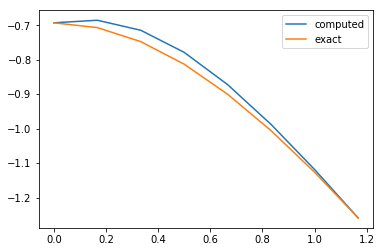

In [0]:
plt.plot(pde1.s_space, pde1.s_val, label = 'computed')

exact_val = pde1.exact_sol(pde1.s_space)
plt.plot(pde1.s_space, exact_val, label = 'exact')
plt.legend()

print('>>>iteration error is ' + str(err))
print('>>>iter number is ' + str(n_iter))
print('>>>max norm of error is ' + str(np.max(np.abs(pde1.s_val-exact_val))))
